In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans

In [2]:
DATA_DIR = Path("./data")

In [3]:
upah = pd.read_csv(DATA_DIR / "upah.df.csv", sep=";")
ump = pd.read_csv(DATA_DIR / "ump.df.csv", sep=";")
gk = pd.read_csv(DATA_DIR / "gk.df.csv", sep=";")
peng = pd.read_csv(DATA_DIR / "peng.df.csv", sep=";")

## Data Cleansing

In [ ]:
valid_daerah = ["PERDESAAN", "PERKOTAAN"]

In [ ]:
gk = gk[gk["daerah"].isin(valid_daerah)]
peng = peng[peng["daerah"].isin(valid_daerah)]

In [6]:
invalid_prov = ["INDONESIA", "CAMPURAN"]

gk = gk[~gk["provinsi"].isin(invalid_prov)]
peng = peng[~peng["provinsi"].isin(invalid_prov)]

In [ ]:
print("GK missing:\n", gk.isna().sum(), "\n")
print("Peng missing:\n", peng.isna().sum(), "\n")
print("UMP missing:\n", ump.isna().sum(), "\n")
print("Upah missing:\n", upah.isna().sum(), "\n")

GK missing:
 provinsi     0
jenis        0
daerah       0
tahun        0
periode      0
gk          59
dtype: int64 

Peng missing:
 provinsi     0
daerah       0
jenis        0
tahun        0
peng        96
dtype: int64 

UMP missing:
 provinsi     0
tahun        0
ump         24
dtype: int64 

Upah missing:
 provinsi    0
tahun       0
upah        0
dtype: int64 



In [ ]:
for df in [gk, peng, ump, upah]:
    df["provinsi"] = df["provinsi"].str.strip().str.upper()

In [ ]:
for df in [gk, peng, ump, upah]:
    df["tahun"] = pd.to_numeric(df["tahun"], errors="coerce")

## Dataset Check

In [ ]:
common_years = sorted(
    list(
        set(gk.tahun).intersection(set(peng.tahun)).intersection(set(upah.tahun))
    )
)

In [11]:
print("Overlapping years:", common_years)

Overlapping years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [ ]:
gk = gk[gk["tahun"].isin(common_years)]
peng = peng[peng["tahun"].isin(common_years)]
upah = upah[upah["tahun"].isin(common_years)]

## Normalization

In [ ]:
for df in [gk, peng]:
    # Uppercase + strip spaces
    df['daerah'] = df['daerah'].str.upper().str.strip()
    df['jenis'] = df['jenis'].str.upper().str.strip()

In [ ]:
gk['periode'] = gk['periode'].str.upper().str.strip()

In [ ]:
replace_map = {
    'PERKOTAAN': 'URBAN',
    'PERDESAAN': 'RURAL'
}

In [16]:
gk['daerah'] = gk['daerah'].replace(replace_map)
peng['daerah'] = peng['daerah'].replace(replace_map)

In [ ]:
invalid_daerah = ['PERDESAANPERKOTAAN']
gk = gk[~gk['daerah'].isin(invalid_daerah)]
peng = peng[~peng['daerah'].isin(invalid_daerah)]

## Data Preparation

In [ ]:
gk = gk[gk['periode'] == 'MARET']

In [22]:
print("Periode unique after filter:", gk['periode'].unique())
print("Jumlah baris GK setelah filter:", len(gk))

Periode unique after filter: ['MARET']
Jumlah baris GK setelah filter: 1632


In [ ]:
gk_wide = gk.pivot_table(index=["provinsi", "tahun", "daerah"],
                         columns="jenis",
                         values="gk").reset_index()

In [24]:
print("Kolom GK setelah pivot:", gk_wide.columns.tolist())
print("Unique jenis GK:", gk["jenis"].unique())

Kolom GK setelah pivot: ['provinsi', 'tahun', 'daerah', 'MAKANAN', 'NONMAKANAN', 'TOTAL']
Unique jenis GK: ['MAKANAN' 'NONMAKANAN' 'TOTAL']


In [25]:
print(gk_wide.columns)

Index(['provinsi', 'tahun', 'daerah', 'MAKANAN', 'NONMAKANAN', 'TOTAL'], dtype='object', name='jenis')


In [ ]:
gk_wide["gk_total"] = gk_wide["MAKANAN"] + gk_wide["NONMAKANAN"]

In [ ]:
peng_wide = peng.pivot_table(index=["provinsi", "tahun", "daerah"],
                             columns="jenis",
                             values="peng").reset_index()

In [28]:
print("\nKolom Pengeluaran setelah pivot:", peng_wide.columns.tolist())
print("Unique jenis Peng:", peng["jenis"].unique())


Kolom Pengeluaran setelah pivot: ['provinsi', 'tahun', 'daerah', 'MAKANAN', 'NONMAKANAN', 'TOTAL']
Unique jenis Peng: ['MAKANAN' 'NONMAKANAN' 'TOTAL']


In [ ]:
peng_wide["peng_total"] = peng_wide["MAKANAN"] + peng_wide["NONMAKANAN"]

In [30]:
print("GK_wide shape:", gk_wide.shape)
print("Peng_wide shape:", peng_wide.shape)
print("\nContoh data GK:\n", gk_wide.head())
print("\nContoh data Peng:\n", peng_wide.head())

GK_wide shape: (536, 7)
Peng_wide shape: (536, 7)

Contoh data GK:
 jenis provinsi  tahun daerah   MAKANAN  NONMAKANAN     TOTAL  gk_total
0         ACEH   2015  RURAL  297479.0     84638.0  382117.0  382117.0
1         ACEH   2015  URBAN  293697.0    116717.0  410414.0  410414.0
2         ACEH   2016  RURAL  315697.0     88288.0  403985.0  403985.0
3         ACEH   2016  URBAN  306243.0    121727.0  427970.0  427970.0
4         ACEH   2017  RURAL  331267.0     94463.0  425730.0  425730.0

Contoh data Peng:
 jenis provinsi  tahun daerah   MAKANAN  NONMAKANAN      TOTAL  peng_total
0         ACEH   2015  RURAL  395136.0    260183.0   655319.0    655319.0
1         ACEH   2015  URBAN  466355.0    529945.0   996300.0    996300.0
2         ACEH   2016  RURAL  412251.0    272829.0   685080.0    685080.0
3         ACEH   2016  URBAN  548853.0    559492.0  1108346.0   1108345.0
4         ACEH   2017  RURAL  494150.0    287004.0   781155.0    781154.0


## Merge Dataset

In [ ]:
df = gk_wide.merge(
    peng_wide[["provinsi", "tahun", "daerah", "peng_total"]],
    on=["provinsi", "tahun", "daerah"],
    how="inner"
)

In [ ]:
df = df.merge(
    upah[["provinsi", "tahun", "upah"]],
    on=["provinsi", "tahun"],
    how="inner"
)

In [ ]:
df = df.merge(
    ump[["provinsi", "tahun", "ump"]],
    on=["provinsi", "tahun"],
    how="inner"
)

In [34]:
print("Final dataframe shape:", df.shape)
print(df.head())

Final dataframe shape: (536, 10)
  provinsi  tahun daerah   MAKANAN  NONMAKANAN     TOTAL  gk_total  \
0     ACEH   2015  RURAL  297479.0     84638.0  382117.0  382117.0   
1     ACEH   2015  URBAN  293697.0    116717.0  410414.0  410414.0   
2     ACEH   2016  RURAL  315697.0     88288.0  403985.0  403985.0   
3     ACEH   2016  URBAN  306243.0    121727.0  427970.0  427970.0   
4     ACEH   2017  RURAL  331267.0     94463.0  425730.0  425730.0   

   peng_total   upah        ump  
0    655319.0  11226  1900000.0  
1    996300.0  11226  1900000.0  
2    685080.0  13627  2118500.0  
3   1108345.0  13627  2118500.0  
4    781154.0  14809  2500000.0  


## EDA

In [39]:
final = df.copy()

In [40]:
final.head()
final.shape

(536, 10)

In [41]:
print("\nStatistik Deskriptif (Garis Kemiskinan vs Pengeluaran):")
display(final[["gk_total", "peng_total"]].describe())


Statistik Deskriptif (Garis Kemiskinan vs Pengeluaran):


,gk_total,peng_total
count,536.000000,5.360000e+02
mean,448402.742537,1.140273e+06
std,108905.774571,3.277119e+05
min,240175.000000,4.483750e+05
25%,369430.750000,8.930460e+05
50%,429896.000000,1.104616e+06
75%,515019.250000,1.346515e+06
max,820543.000000,2.525346e+06


In [42]:
print("\nStatistik Deskriptif (Upah & UMP):")
display(final[["upah", "ump"]].describe())


Statistik Deskriptif (Upah & UMP):


,upah,ump
count,536.000000,5.360000e+02
mean,16515.279851,2.294018e+06
std,4265.418971,5.882835e+05
min,8525.000000,9.100000e+05
25%,13372.750000,1.870000e+06
50%,15840.500000,2.258000e+06
75%,18626.000000,2.678863e+06
max,32685.000000,4.641854e+06


In [43]:
print("\nCek nilai minimum & maksimum setiap indikator:")
print(final[["gk_total", "peng_total", "upah", "ump"]].agg(["min","max"]))


Cek nilai minimum & maksimum setiap indikator:
     gk_total  peng_total   upah        ump
min  240175.0    448375.0   8525   910000.0
max  820543.0   2525346.0  32685  4641854.0


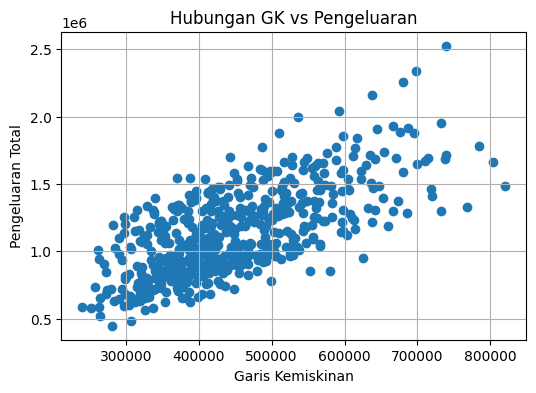

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(final["gk_total"], final["peng_total"])
plt.xlabel("Garis Kemiskinan")
plt.ylabel("Pengeluaran Total")
plt.title("Hubungan GK vs Pengeluaran")
plt.grid(True)
plt.show()

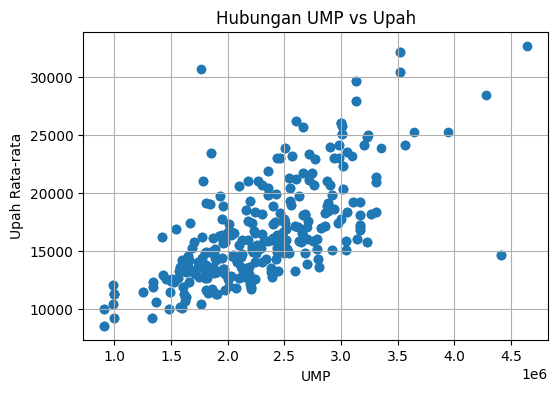

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(final["ump"], final["upah"])
plt.xlabel("UMP")
plt.ylabel("Upah Rata-rata")
plt.title("Hubungan UMP vs Upah")
plt.grid(True)
plt.show()

In [ ]:
final["upah_bulan"] = final["upah"] * 8 * 22

In [ ]:
final["welfare_ratio"] = final["upah_bulan"] / final["peng_total"]

In [ ]:
final["poverty_gap"] = final["upah_bulan"] - final["gk_total"]

In [49]:
print(final.head())
print("\nRingkasan WR & PG:")
display(final[["welfare_ratio", "poverty_gap"]].describe())

  provinsi  tahun daerah   MAKANAN  NONMAKANAN     TOTAL  gk_total  \
0     ACEH   2015  RURAL  297479.0     84638.0  382117.0  382117.0   
1     ACEH   2015  URBAN  293697.0    116717.0  410414.0  410414.0   
2     ACEH   2016  RURAL  315697.0     88288.0  403985.0  403985.0   
3     ACEH   2016  URBAN  306243.0    121727.0  427970.0  427970.0   
4     ACEH   2017  RURAL  331267.0     94463.0  425730.0  425730.0   

   peng_total   upah        ump  upah_bulan  welfare_ratio  poverty_gap  
0    655319.0  11226  1900000.0     1975776       3.014984    1593659.0  
1    996300.0  11226  1900000.0     1975776       1.983114    1565362.0  
2    685080.0  13627  2118500.0     2398352       3.500835    1994367.0  
3   1108345.0  13627  2118500.0     2398352       2.163904    1970382.0  
4    781154.0  14809  2500000.0     2606384       3.336582    2180654.0  

Ringkasan WR & PG:


,welfare_ratio,poverty_gap
count,536.000000,5.360000e+02
mean,2.664871,2.458287e+06
std,0.730820,6.886570e+05
min,1.499136,1.201389e+06
25%,2.092317,1.962092e+06
50%,2.542176,2.323659e+06
75%,3.031485,2.793764e+06
max,6.037511,5.113593e+06


In [50]:
final["provinsi"].unique()

array(['ACEH', 'BALI', 'BANTEN', 'BENGKULU', 'DI YOGYAKARTA',
       'DKI JAKARTA', 'GORONTALO', 'JAMBI', 'JAWA BARAT', 'JAWA TENGAH',
       'JAWA TIMUR', 'KALIMANTAN BARAT', 'KALIMANTAN SELATAN',
       'KALIMANTAN TENGAH', 'KALIMANTAN TIMUR', 'KALIMANTAN UTARA',
       'KEP. BANGKA BELITUNG', 'KEP. RIAU', 'LAMPUNG', 'MALUKU',
       'MALUKU UTARA', 'NUSA TENGGARA BARAT', 'NUSA TENGGARA TIMUR',
       'PAPUA', 'PAPUA BARAT', 'RIAU', 'SULAWESI BARAT',
       'SULAWESI SELATAN', 'SULAWESI TENGAH', 'SULAWESI TENGGARA',
       'SULAWESI UTARA', 'SUMATERA BARAT', 'SUMATERA SELATAN',
       'SUMATERA UTARA'], dtype=object)

In [51]:
final.describe()

,tahun,MAKANAN,NONMAKANAN,TOTAL,gk_total,peng_total,upah,ump,upah_bulan,welfare_ratio,poverty_gap
count,536.000000,536.000000,536.000000,536.000000,536.000000,5.360000e+02,536.000000,5.360000e+02,5.360000e+02,536.000000,5.360000e+02
mean,2018.500000,332430.791045,115971.951493,448402.800373,448402.742537,1.140273e+06,16515.279851,2.294018e+06,2.906689e+06,2.664871,2.458287e+06
std,2.293428,76996.277463,37545.595413,108905.735718,108905.774571,3.277119e+05,4265.418971,5.882835e+05,7.507137e+05,0.730820,6.886570e+05
min,2015.000000,181842.000000,48561.000000,240175.000000,240175.000000,4.483750e+05,8525.000000,9.100000e+05,1.500400e+06,1.499136,1.201389e+06
25%,2016.750000,275075.750000,88235.750000,369430.750000,369430.750000,8.930460e+05,13372.750000,1.870000e+06,2.353604e+06,2.092317,1.962092e+06
50%,2018.500000,320759.000000,109302.500000,429896.000000,429896.000000,1.104616e+06,15840.500000,2.258000e+06,2.787928e+06,2.542176,2.323659e+06
75%,2020.250000,380790.000000,137488.500000,515019.500000,515019.250000,1.346515e+06,18626.000000,2.678863e+06,3.278176e+06,3.031485,2.793764e+06
max,2022.000000,600254.000000,233682.000000,820543.000000,820543.000000,2.525346e+06,32685.000000,4.641854e+06,5.752560e+06,6.037511,5.113593e+06


In [52]:
final.groupby("daerah")[["welfare_ratio", "poverty_gap"]].mean()

,welfare_ratio,poverty_gap
daerah,,
RURAL,3.197194,2.450818e+06
URBAN,2.148205,2.465536e+06


## Visualization

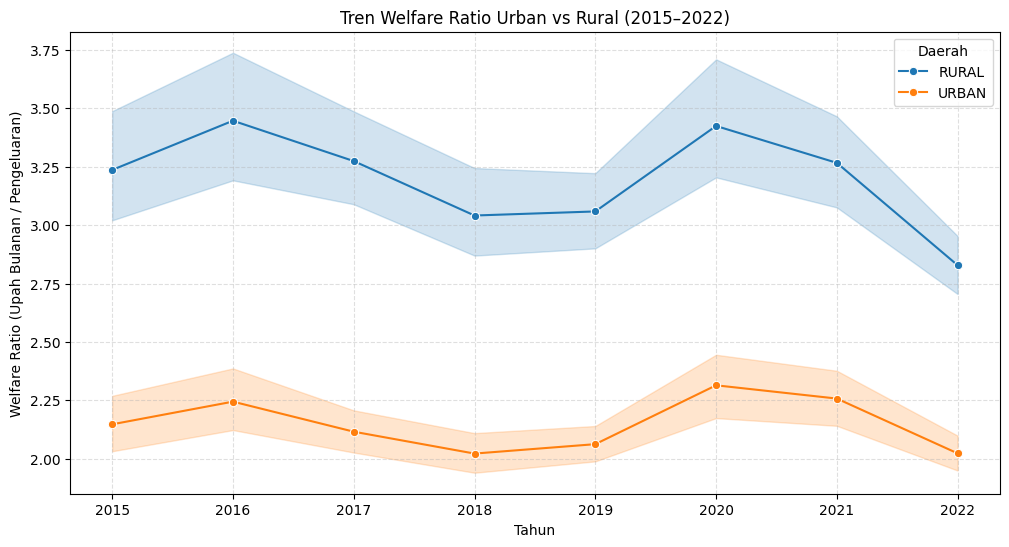

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=final, x="tahun", y="welfare_ratio", hue="daerah", marker="o")
plt.title("Tren Welfare Ratio Urban vs Rural (2015–2022)")
plt.xlabel("Tahun")
plt.ylabel("Welfare Ratio (Upah Bulanan / Pengeluaran)")
plt.legend(title="Daerah")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

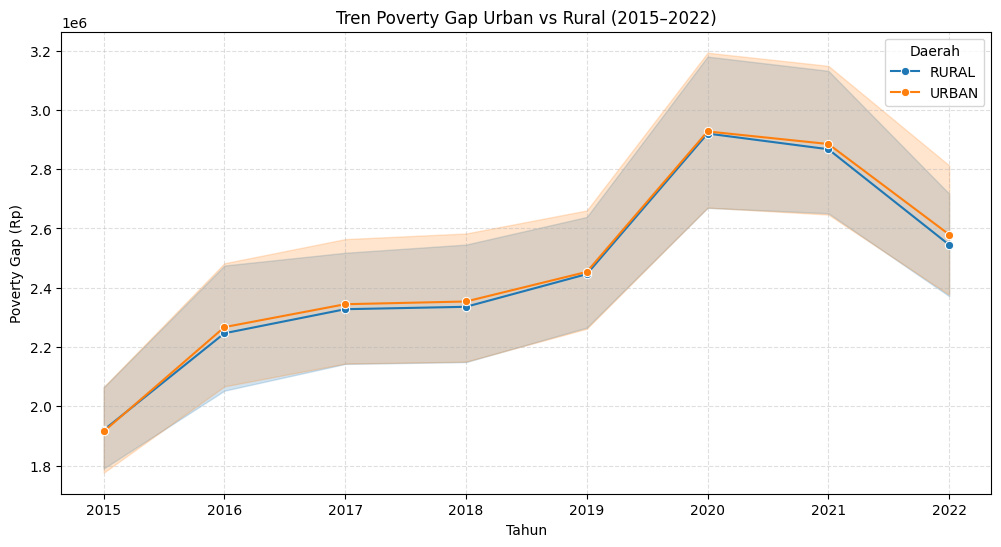

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=final, x="tahun", y="poverty_gap", hue="daerah", marker="o")
plt.title("Tren Poverty Gap Urban vs Rural (2015–2022)")
plt.xlabel("Tahun")
plt.ylabel("Poverty Gap (Rp)")
plt.legend(title="Daerah")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

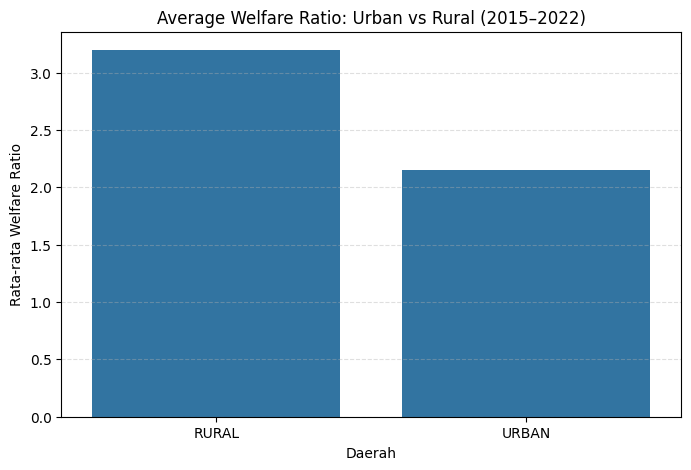

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=final,
    x="daerah",
    y="welfare_ratio",
    estimator="mean",
    errorbar=None
)
plt.title("Average Welfare Ratio: Urban vs Rural (2015–2022)")
plt.xlabel("Daerah")
plt.ylabel("Rata-rata Welfare Ratio")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

## Modeling

In [56]:
# Tujuan - Melihap apakah kenaikan upah berpengaruh
# signifikan terhadap kesejahteraan (welfare ratio)

# Varaibel:
# dependen > welfare_ratio
# independen > upah (alternatif: upah_bulan)
# kontrol > gk_total dan dummy daerah (urban/rural)
# efek tetap per-provinsi + tahun > mengontrol karakteristik
# daerah dan shock tahunan

In [57]:
# model regresi panel fixed effect per-provinsi dan tahun
# analisis regresi linear (OLS) dengan library statsmodels
# tujuan: ubtuk menjawab faktor apa saja yang mempengaruhi
# welfare ratio pekerja di indonesia

model = smf.ols(
    "welfare_ratio ~ upah + gk_total + C(daerah) + C(provinsi) + C(tahun)",
    data=final
).fit(cov_type='HC3')  # heteroskedasticity robust

In [58]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          welfare_ratio   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     86.97
Date:                Mon, 01 Dec 2025   Prob (F-statistic):          2.24e-201
Time:                        12:09:52   Log-Likelihood:                 24.376
No. Observations:                 536   AIC:                             39.25
Df Residuals:                     492   BIC:                             227.7
Df Model:                          43                                         
Covariance Type:                  HC3                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

## Clustering

In [ ]:
df_cluster = final.copy()

In [ ]:
X = df_cluster[["welfare_ratio", "poverty_gap"]]

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(X)

In [ ]:
cluster_labels = ["Cluster 1", "Cluster 2", "Cluster 3"]
df_cluster["cluster_label"] = df_cluster["cluster"].map(lambda x: cluster_labels[x])

In [ ]:
urban = df_cluster[df_cluster["daerah"] == "URBAN"]
rural = df_cluster[df_cluster["daerah"] == "RURAL"]

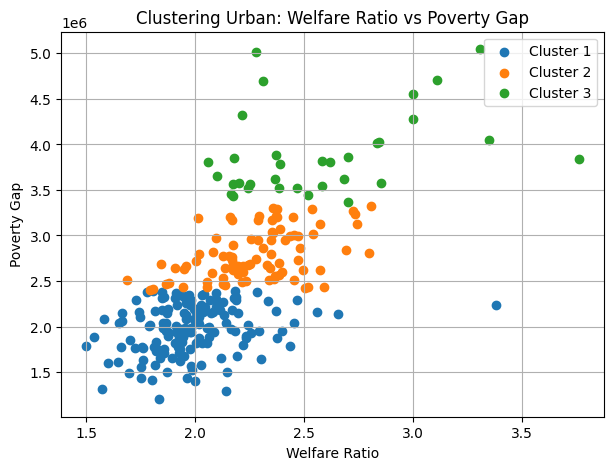

In [ ]:
plt.figure(figsize=(7,5))
for c in cluster_labels:
    temp = urban[urban["cluster_label"] == c]
    plt.scatter(temp["welfare_ratio"], temp["poverty_gap"], label=c)
plt.title("Clustering Urban: Welfare Ratio vs Poverty Gap")
plt.xlabel("Welfare Ratio")
plt.ylabel("Poverty Gap")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
urban_cluster_table = urban[["provinsi", "daerah", "tahun", "cluster_label", "welfare_ratio", "poverty_gap"]]
print(urban_cluster_table.sort_values("cluster_label"))

              provinsi daerah  tahun cluster_label  welfare_ratio  poverty_gap
1                 ACEH  URBAN   2015     Cluster 1       1.983114    1565362.0
295            LAMPUNG  URBAN   2022     Cluster 1       1.763359    1765901.0
297             MALUKU  URBAN   2015     Cluster 1       2.561012    2156053.0
303             MALUKU  URBAN   2018     Cluster 1       2.006284    2158721.0
311             MALUKU  URBAN   2022     Cluster 1       2.040642    2353707.0
..                 ...    ...    ...           ...            ...          ...
43              BANTEN  URBAN   2020     Cluster 3       2.383924    3526383.0
85         DKI JAKARTA  URBAN   2020     Cluster 3       2.215208    4321519.0
84         DKI JAKARTA  URBAN   2019     Cluster 3       2.059976    3804276.0
229   KALIMANTAN TIMUR  URBAN   2021     Cluster 3       2.244647    3518144.0
459  SULAWESI TENGGARA  URBAN   2016     Cluster 3       3.763205    3836317.0

[272 rows x 6 columns]


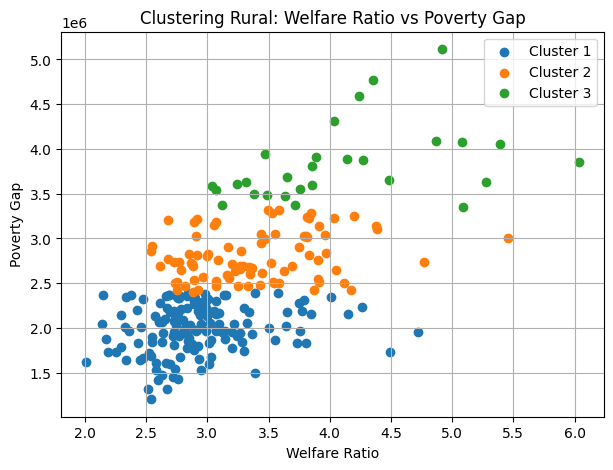

In [ ]:
plt.figure(figsize=(7,5))
for c in cluster_labels:
    temp = rural[rural["cluster_label"] == c]
    plt.scatter(temp["welfare_ratio"], temp["poverty_gap"], label=c)
plt.title("Clustering Rural: Welfare Ratio vs Poverty Gap")
plt.xlabel("Welfare Ratio")
plt.ylabel("Poverty Gap")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
rural_cluster_table = rural[["provinsi", "daerah", "tahun", "cluster_label", "welfare_ratio", "poverty_gap"]]
print(rural_cluster_table.sort_values("cluster_label"))

              provinsi daerah  tahun cluster_label  welfare_ratio  poverty_gap
0                 ACEH  RURAL   2015     Cluster 1       3.014984    1593659.0
302             MALUKU  RURAL   2018     Cluster 1       3.648295    2178111.0
310             MALUKU  RURAL   2022     Cluster 1       3.151853    2367854.0
312       MALUKU UTARA  RURAL   2015     Cluster 1       3.323497    2057044.0
314       MALUKU UTARA  RURAL   2016     Cluster 1       3.789051    2308487.0
..                 ...    ...    ...           ...            ...          ...
226   KALIMANTAN TIMUR  RURAL   2020     Cluster 3       3.041542    3588452.0
46              BANTEN  RURAL   2022     Cluster 3       3.651544    3681568.0
458  SULAWESI TENGGARA  RURAL   2016     Cluster 3       6.037511    3854183.0
370              PAPUA  RURAL   2020     Cluster 3       4.919786    5113593.0
270          KEP. RIAU  RURAL   2018     Cluster 3       3.758848    3556524.0

[264 rows x 6 columns]


In [69]:
cluster_summary = df_cluster.groupby(["cluster_label","provinsi", "daerah"]).agg({
    "welfare_ratio": "mean",
    "poverty_gap": "mean"
}).reset_index()

In [70]:
with pd.ExcelWriter("hasil_kesejahteraan2.xlsx", engine="openpyxl") as writer:
    final.to_excel(writer, sheet_name="Final Data", index=False)
    urban_cluster_table.to_excel(writer, sheet_name="Urban Clusters", index=False)
    rural_cluster_table.to_excel(writer, sheet_name="Rural Cluster", index=False)
    cluster_summary.to_excel(writer, sheet_name="Cluster Summary", index=False)